In [1]:
!pip install numpy==1.23.5 pandas==1.5.3  # 버전 호환성 보장
!pip install optuna scikit-learn matplotlib

  Using cached optuna-4.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
Using cached optuna-4.2.1-py3-none-any.whl (383 kB)
Using cached alembic-1.15.2-py3-none-any.whl (231 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)


In [2]:
# 필요한 라이브러리 설치
!pip install optuna


# 데이터 로드 및 전처리

In [3]:
# 데이터 로드
import pandas as pd

# 파일 업로드
from google.colab import files
uploaded = files.upload()

# 파일 읽기 (인코딩 문제 해결)
data = pd.read_csv("iptv_data(50000).csv", encoding='latin1')


Saving iptv_data(50000).csv to iptv_data(50000).csv


In [4]:
# 데이터 전처리 전체 코드 (경고 없음)
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# 데이터 로드 및 결측값 처리
data = pd.read_csv("iptv_data(50000).csv", encoding='latin1')
data_cleaned = data.dropna().copy()

# 타겟 변수 분리
y = data_cleaned['iptv_yn']
X = data_cleaned.drop(columns=['iptv_yn'])

# 범주형/수치형 분리
categorical_cols = [
    'ContractPVCName',
    'ResidenceBuildingTypeCode',
    'Gender',
    'ReAgreementYesNo',
    'TransferYesNo',
    'WifiSubscriptionYesNo',
    'SalesSmallYesNo',
    'InternetProductName',
    'MaxGeneralConsultationCount',
    'MaxQualityConsultationCount',
    'MaxTermConsultationCount',
    'MaxSaleConsultationCount',
    'MaxFeeConsultationCount',
    'MaxEtcConsultationCount',
    'AgeGroup'
]
numerical_cols = [col for col in X.columns if col not in categorical_cols]

X_cat = X[categorical_cols].copy()  # 복사본 생성
X_num = X[numerical_cols].copy()

# 범주형 변수 인코딩
for col in categorical_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col].astype(str))

# 수치형 변수 스케일링
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=numerical_cols)

# 데이터 병합
X_processed = pd.concat([X_cat, X_num_scaled], axis=1)

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# 클래스 가중치 적용 및 모델 학습 (Random Forest)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# 교차 검증 (StratifiedKFold)
skf = StratifiedKFold(n_splits=5)
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_model.fit(X_fold_train, y_fold_train)
    score = rf_model.score(X_fold_val, y_fold_val)
    print(f"Fold {fold_idx + 1} Validation Score: {score:.3f}")


Fold 1 Validation Score: 0.887
Fold 2 Validation Score: 0.890
Fold 3 Validation Score: 0.886
Fold 4 Validation Score: 0.883
Fold 5 Validation Score: 0.892


# 랜덤포레스트와 Optuna를 사용한 하이퍼파라미터 튜닝

In [5]:
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.metrics import roc_auc_score

# 1. Optuna 하이퍼파라미터 튜닝 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 50, 200),
        'max_depth': trial.suggest_int("max_depth", 5, 20),
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
        'class_weight': 'balanced',
        'random_state': 42
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)  # 원본 데이터 사용
    y_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_proba)

# Optuna 실행 (최적화)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=600)

# 최적 하이퍼파라미터로 모델 생성
best_params = study.best_params
rf_best = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
rf_best.fit(X_train, y_train)

print("\n최적 하이퍼파라미터:")
print(best_params)

[I 2025-04-10 11:16:51,382] A new study created in memory with name: no-name-42c3a29f-b324-40ec-92cf-6733922e9f8c
[I 2025-04-10 11:16:54,851] Trial 0 finished with value: 0.8922631303774472 and parameters: {'n_estimators': 126, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8922631303774472.
[I 2025-04-10 11:16:57,242] Trial 1 finished with value: 0.8940860846654083 and parameters: {'n_estimators': 90, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8940860846654083.
[I 2025-04-10 11:17:00,266] Trial 2 finished with value: 0.8951240024321051 and parameters: {'n_estimators': 124, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8951240024321051.
[I 2025-04-10 11:17:02,358] Trial 3 finished with value: 0.8934548406881228 and parameters: {'n_estimators': 115, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 2 with value:


최적 하이퍼파라미터:
{'n_estimators': 91, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 9}


# 성능 평가 및 시각화


Fold 1 Classification Report:
              precision    recall  f1-score   support

           N       0.37      0.79      0.51       823
           Y       0.97      0.81      0.88      5882

    accuracy                           0.81      6705
   macro avg       0.67      0.80      0.69      6705
weighted avg       0.89      0.81      0.84      6705


Fold 2 Classification Report:
              precision    recall  f1-score   support

           N       0.36      0.79      0.50       823
           Y       0.97      0.81      0.88      5882

    accuracy                           0.80      6705
   macro avg       0.66      0.80      0.69      6705
weighted avg       0.89      0.80      0.83      6705


Fold 3 Classification Report:
              precision    recall  f1-score   support

           N       0.37      0.80      0.51       822
           Y       0.97      0.81      0.88      5882

    accuracy                           0.81      6704
   macro avg       0.67      0.81  

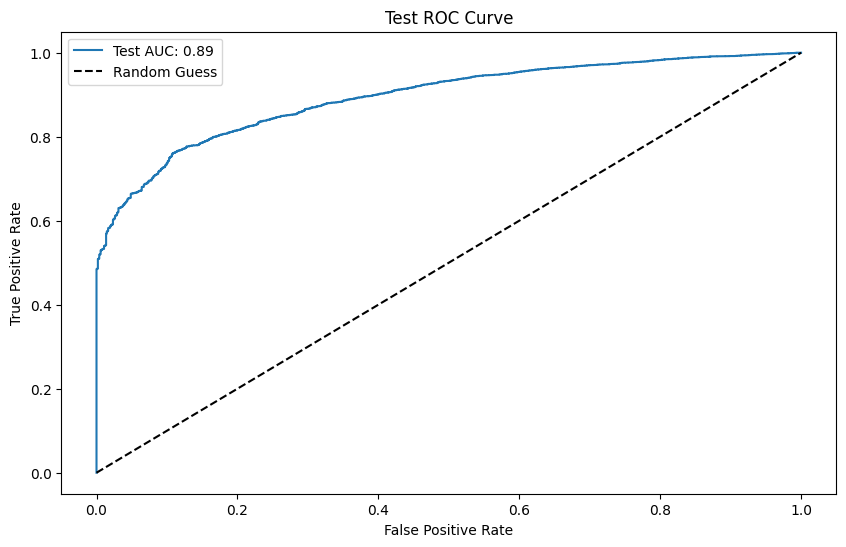

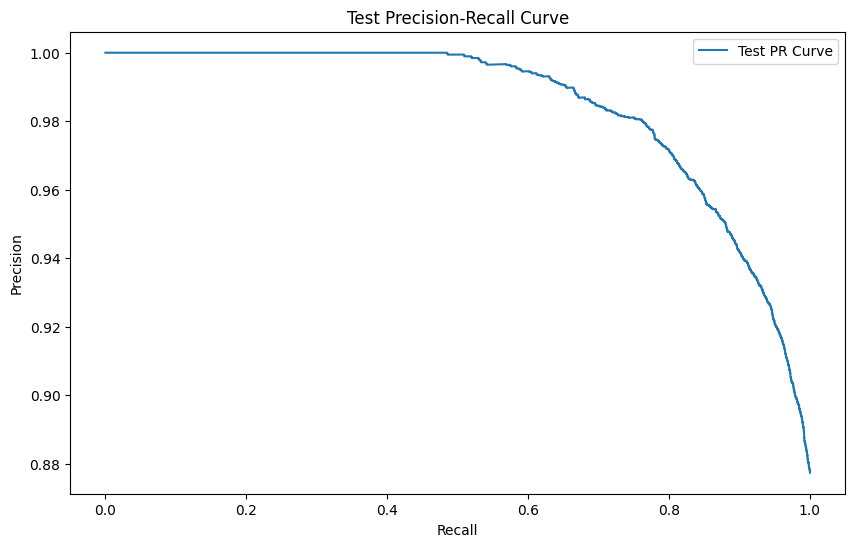


테스트 데이터 Classification Report:
              precision    recall  f1-score   support

           N       0.38      0.80      0.51      1028
           Y       0.97      0.82      0.88      7353

    accuracy                           0.81      8381
   macro avg       0.67      0.81      0.70      8381
weighted avg       0.89      0.81      0.84      8381



In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def calculate_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (Y)': precision_score(y_true, y_pred, pos_label='Y'),
        'Recall (Y)': recall_score(y_true, y_pred, pos_label='Y'),
        'F1 (Y)': f1_score(y_true, y_pred, pos_label='Y'),
        'Precision (N)': precision_score(y_true, y_pred, pos_label='N'),
        'Recall (N)': recall_score(y_true, y_pred, pos_label='N'),
        'F1 (N)': f1_score(y_true, y_pred, pos_label='N'),
        'ROC-AUC': roc_auc_score((y_true == 'Y').astype(int), y_proba)
    }

def run_cross_validation(model, X, y):
    skf = StratifiedKFold(n_splits=5)
    fold_metrics = []
    class_reports = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx].values, y.iloc[val_idx].values

        rf_best.fit(X_train_fold, y_train_fold)
        y_pred = rf_best.predict(X_val_fold)
        y_proba = rf_best.predict_proba(X_val_fold)[:, 1]

        # 분류 리포트 생성
        report = classification_report(y_val_fold, y_pred, target_names=['N', 'Y'], output_dict=True)

        # 메트릭 수집
        fold_metric = {
            'Fold': fold_idx + 1,
            'N Precision': report['N']['precision'],
            'N Recall': report['N']['recall'],
            'N F1': report['N']['f1-score'],
            'Y Precision': report['Y']['precision'],
            'Y Recall': report['Y']['recall'],
            'Y F1': report['Y']['f1-score'],
            'Accuracy': report['accuracy'],
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1': report['macro avg']['f1-score'],
            'Weighted Precision': report['weighted avg']['precision'],
            'Weighted Recall': report['weighted avg']['recall'],
            'Weighted F1': report['weighted avg']['f1-score'],
            'Support N': report['N']['support'],
            'Support Y': report['Y']['support']
        }
        fold_metrics.append(fold_metric)

        print(f"\nFold {fold_idx+1} Classification Report:")
        print(classification_report(y_val_fold, y_pred, target_names=['N', 'Y']))

    # 평균값 계산
    avg_metrics = {
        'Fold': 'Average',
        'N Precision': np.mean([m['N Precision'] for m in fold_metrics]),
        'N Recall': np.mean([m['N Recall'] for m in fold_metrics]),
        'N F1': np.mean([m['N F1'] for m in fold_metrics]),
        'Y Precision': np.mean([m['Y Precision'] for m in fold_metrics]),
        'Y Recall': np.mean([m['Y Recall'] for m in fold_metrics]),
        'Y F1': np.mean([m['Y F1'] for m in fold_metrics]),
        'Accuracy': np.mean([m['Accuracy'] for m in fold_metrics]),
        'Macro Precision': np.mean([m['Macro Precision'] for m in fold_metrics]),
        'Macro Recall': np.mean([m['Macro Recall'] for m in fold_metrics]),
        'Macro F1': np.mean([m['Macro F1'] for m in fold_metrics]),
        'Weighted Precision': np.mean([m['Weighted Precision'] for m in fold_metrics]),
        'Weighted Recall': np.mean([m['Weighted Recall'] for m in fold_metrics]),
        'Weighted F1': np.mean([m['Weighted F1'] for m in fold_metrics]),
        'Support N': np.mean([m['Support N'] for m in fold_metrics]),
        'Support Y': np.mean([m['Support Y'] for m in fold_metrics])
    }

    # 결과 테이블 생성
    results_df = pd.DataFrame(fold_metrics + [avg_metrics])
    results_df = results_df.set_index('Fold')

    # 리포트 포맷팅
    print("\n" + "="*50)
    print("교차 검증 최종 결과 (평균값 포함)")
    print(results_df.round(3))
    print("="*50)

    return results_df

# 1. 교차 검증 실행
cv_results = run_cross_validation(rf_best, X_train, y_train)

# 2. 최종 테스트 평가
y_test_pred = rf_best.predict(X_test)
y_test_pred_proba = rf_best.predict_proba(X_test)[:, 1]

test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)
test_df = pd.DataFrame([test_metrics], index=['Test'])

print("\n" + "="*50)
print("최종 테스트 결과:")
print(test_df.round(3))
print("="*50)

# 학습/테스트 성능 비교
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba)


# ROC-AUC 커브 비교
fpr_test, tpr_test, _ = roc_curve((y_test == 'Y').astype(int), y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, label=f'Test AUC: {roc_auc_score((y_test == "Y").astype(int), y_test_pred_proba):.2f}')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC Curve')
plt.legend()
plt.show()

# PR 커브 비교
precision_test, recall_test, _ = precision_recall_curve((y_test == 'Y').astype(int), y_test_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall_test, precision_test, label='Test PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Precision-Recall Curve')
plt.legend()
plt.show()

# Classification Report (타겟 이름 명시적 지정)

print("\n테스트 데이터 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['N', 'Y']))